# House Prices: Advanced Regression Techniques

---

Reference<br>
https://www.kaggle.com/kongnyooong/house-price-tutorial-for-korean-beginners<br>
Dataset<br>
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

# 1. Dataset Upload from Kaggle



In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nowhere3070","key":"6c11d88801317b52affd0c27ad4a6e13"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 12.1MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 60.8MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 11.8MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 62.9MB/s]


In [ ]:
!ls

data_description.txt  sample_data	     test.csv
kaggle.json	      sample_submission.csv  train.csv


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!cp train.csv /content/gdrive/My\ Drive/Project/House\ Prices:\ Advanced\ Regression\ Techniques/dataset
!cp test.csv /content/gdrive/My\ Drive/Project/House\ Prices:\ Advanced\ Regression\ Techniques/dataset
!cp sample_submission.csv /content/gdrive/My\ Drive/Project/House\ Prices:\ Advanced\ Regression\ Techniques/dataset

In [ ]:
%cd /content/gdrive/My\ Drive/Project/House\ Prices:\ Advanced\ Regression\ Techniques

/content/gdrive/My Drive/Project/House Prices: Advanced Regression Techniques


# 2. Dataset Check

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!ls

 dataset  'House Prices.ipynb'


In [ ]:
housing_train = pd.read_csv('dataset/train.csv')
housing_test = pd.read_csv('dataset/test.csv')

In [ ]:
housing_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
housing_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [ ]:
housing_train.shape, housing_test.shape

((1460, 81), (1459, 80))

In [ ]:
numerical_feats = housing_train.dtypes[housing_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = housing_test.dtypes[housing_test.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


이상치 탐색 및 제거

In [ ]:
def detect_outliers(df, n, features):   # features: Numerical features
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)  # 빈도를 dictionary type으로 return
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers    # column별 outlier를 많이 포함하고 있는 row
        
Outliers_to_drop = detect_outliers(housing_train, 2, ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'])  # SalePrice 제외

# train 데이터의 이상치를 탐색합니다.
# IQR(튜키의 방법)을 이용한 함수를 지정하여 이상치 탐색을 수행합니다.

In [ ]:
housing_train.loc[Outliers_to_drop].shape

# 이상치가 발견된 행을 확인합니다.

(122, 81)

In [ ]:
housing_train = housing_train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
housing_train.shape

# 이상치들을 제거해주고, 결과를 확인합니다.
# 행의 수가 1338로 줄어든것을 확인할 수 있습니다.

(1338, 81)

결측치 확인

In [ ]:
for col in housing_train.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (housing_train[col].isnull().sum() / housing_train[col].shape[0]))
    print(msperc)

# train 데이터 각 column의 결측치가 몇 %인지 확인합니다. 
# df_train[col].isnull().sum() : 해당 열의 결측치가 몇개인지 알 수 있게하는 문장입니다. (TRUE=1(결측치), FALSE=0으로 계산)
# df_train[col].shape[0] : 해당 열의 차원 (열이 지정되어 있으므로 행의 갯수를 보여줍니다.)
# 100 * (df_train[col].isnull().sum() / df_train[col].shape[0] : 위의 설명을 통해 %를 출력해주는 문장임을 알 수 있습니다.

column:         Id	 Percent of NaN value: 0.00%
column: MSSubClass	 Percent of NaN value: 0.00%
column:   MSZoning	 Percent of NaN value: 0.00%
column: LotFrontage	 Percent of NaN value: 17.12%
column:    LotArea	 Percent of NaN value: 0.00%
column:     Street	 Percent of NaN value: 0.00%
column:      Alley	 Percent of NaN value: 94.10%
column:   LotShape	 Percent of NaN value: 0.00%
column: LandContour	 Percent of NaN value: 0.00%
column:  Utilities	 Percent of NaN value: 0.00%
column:  LotConfig	 Percent of NaN value: 0.00%
column:  LandSlope	 Percent of NaN value: 0.00%
column: Neighborhood	 Percent of NaN value: 0.00%
column: Condition1	 Percent of NaN value: 0.00%
column: Condition2	 Percent of NaN value: 0.00%
column:   BldgType	 Percent of NaN value: 0.00%
column: HouseStyle	 Percent of NaN value: 0.00%
column: OverallQual	 Percent of NaN value: 0.00%
column: OverallCond	 Percent of NaN value: 0.00%
column:  YearBuilt	 Percent of NaN value: 0.00%
column: YearRemodAdd	 Percent of

In [ ]:
for col in housing_test.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (housing_test[col].isnull().sum() / housing_test[col].shape[0]))
    print(msperc)

# test 데이터도 확인해줍니다.
# train, test 모두 PoolQc 데이터가 가장 결측치가 많습니다.

column:         Id	 Percent of NaN value: 0.00%
column: MSSubClass	 Percent of NaN value: 0.00%
column:   MSZoning	 Percent of NaN value: 0.27%
column: LotFrontage	 Percent of NaN value: 15.56%
column:    LotArea	 Percent of NaN value: 0.00%
column:     Street	 Percent of NaN value: 0.00%
column:      Alley	 Percent of NaN value: 92.67%
column:   LotShape	 Percent of NaN value: 0.00%
column: LandContour	 Percent of NaN value: 0.00%
column:  Utilities	 Percent of NaN value: 0.14%
column:  LotConfig	 Percent of NaN value: 0.00%
column:  LandSlope	 Percent of NaN value: 0.00%
column: Neighborhood	 Percent of NaN value: 0.00%
column: Condition1	 Percent of NaN value: 0.00%
column: Condition2	 Percent of NaN value: 0.00%
column:   BldgType	 Percent of NaN value: 0.00%
column: HouseStyle	 Percent of NaN value: 0.00%
column: OverallQual	 Percent of NaN value: 0.00%
column: OverallCond	 Percent of NaN value: 0.00%
column:  YearBuilt	 Percent of NaN value: 0.00%
column: YearRemodAdd	 Percent of

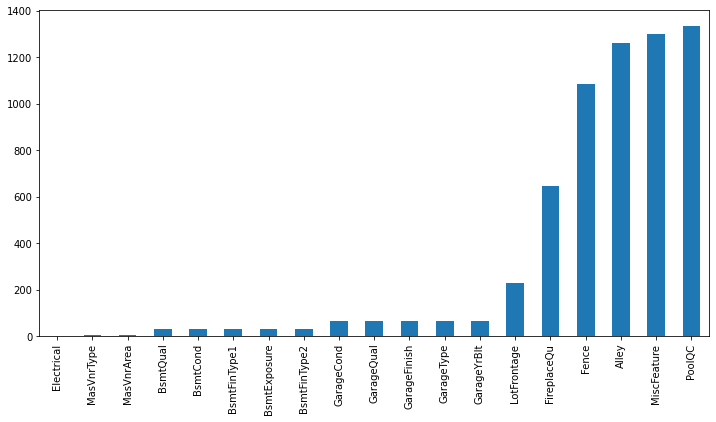

In [ ]:
missing = housing_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize = (12,6))

# 직관적으로 확인하기 위해 barplot을 그려봅니다.

Skewness (비대칭도) 확인

<img src='https://i.imgur.com/ayq6u4D.png' width='100%'>

<img src='https://i.imgur.com/eWouxAW.png' width='100%'>

In [ ]:
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(housing_train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(housing_train[col].kurt())  
         )
    
# 수치형 변수의 Skewness(비대칭도, 왜도), Kurtosis(첨도)를 확인합니다.
# 이는 분포가 얼마나 비대칭을 띄는가 알려주는 척도입니다. (비대칭도: a=0이면 정규분포, a<0 이면 오른쪽으로 치우침, a>0이면 왼쪽으로 치우침)
# 비대칭도와 첨도를 띄는 변수가 여럿 보입니다. Target Feature인 "SalePrice" 또한 약간의 정도를 보이는 것으로 보입니다.

Id              Skewness: 00.00     Kurtosis: -01.19
MSSubClass      Skewness: 01.37     Kurtosis: 001.49
LotFrontage     Skewness: 01.59     Kurtosis: 013.04
LotArea         Skewness: 07.78     Kurtosis: 123.55
OverallQual     Skewness: 00.16     Kurtosis: -00.05
OverallCond     Skewness: 00.74     Kurtosis: 001.23
YearBuilt       Skewness: -0.58     Kurtosis: -00.60
YearRemodAdd    Skewness: -0.52     Kurtosis: -01.27
MasVnrArea      Skewness: 02.69     Kurtosis: 011.04
BsmtFinSF1      Skewness: 00.65     Kurtosis: -00.50
BsmtFinSF2      Skewness: 04.86     Kurtosis: 026.86
BsmtUnfSF       Skewness: 00.87     Kurtosis: 000.29
TotalBsmtSF     Skewness: 00.29     Kurtosis: 001.17
1stFlrSF        Skewness: 00.66     Kurtosis: 000.02
2ndFlrSF        Skewness: 00.77     Kurtosis: -00.80
LowQualFinSF    Skewness: 12.74     Kurtosis: 170.50
GrLivArea       Skewness: 00.66     Kurtosis: 000.54
BsmtFullBath    Skewness: 00.56     Kurtosis: -00.96
BsmtHalfBath    Skewness: 04.91     Kurtosis: 

# 3. EDA

## 3.1. Numerical Data 탐색

수치형 데이터들을 알아보기 위해 다음 4가지의 Plot을 그립니다.
* Correlation Heat Map
* Zoomed Heat Map
* Pair Plot
* Scatter Plot

### Correlation Heat Map

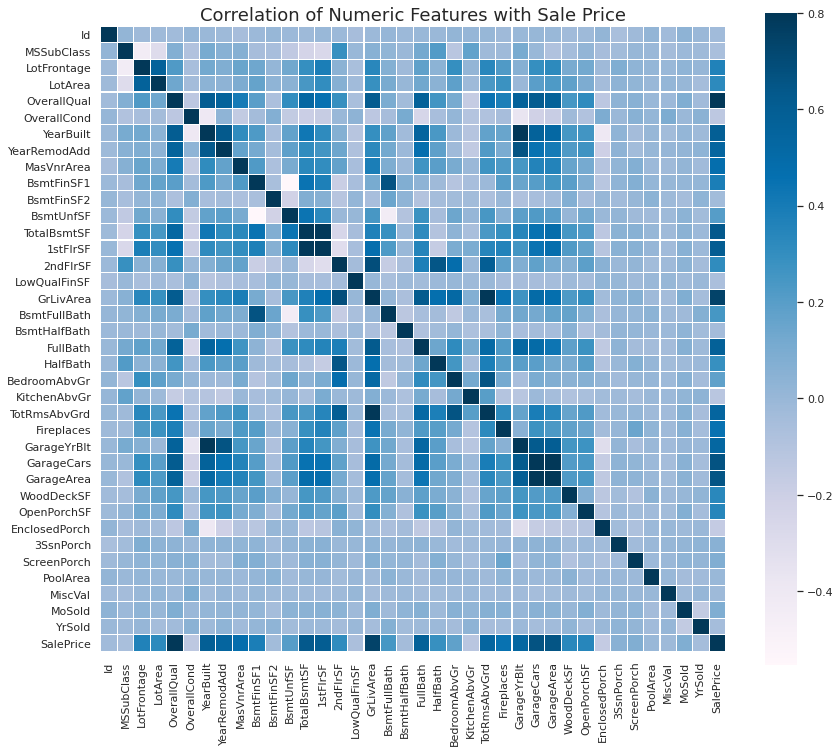

In [ ]:
corr_data = housing_train[['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
                      'MiscVal', 'MoSold', 'YrSold', 'SalePrice']]

colormap = plt.cm.PuBu
sns.set(font_scale=1.0)

f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features with Sale Price',y=1,size=18)
sns.heatmap(corr_data.corr(),square = True, linewidths = 0.1,
            cmap = colormap, linecolor = "white", vmax=0.8)

# Heat Map은 seaborn 덕분에 직관적으로 이해가 가능하여 변수 간 상관관계에 대하여 쉽게 알 수 있습니다.
# 또한 변수 간 다중 공선성을 감지하는 데 유용합니다.
# 대각선 열을 제외한 박스 중 가장 진한 파란색을 띄는 박스가 보입니다.
# 첫 번째는 'TotalBsmtSF'와 '1stFlrSF'변수의 관계입니다.
# 두 번째는 'Garage'와 관련한 변수를 나타냅니다. 
# 두 경우 모두 변수 사이의 상관 관계가 너무 강하여 다중 공선성(MultiColarisity) 상황이 나타날 수 있습니다.
# 변수가 거의 동일한 정보를 제공하므로 다중 공선성이 실제로 발생한다는 결론을 내릴 수 있습니다.
# 또한 확인해야할 부분은 'SalePrice'와의 상관 관계입니다. 
# 'GrLivArea', 'TotalBsmtSF'및 'OverallQual'은 큰 관계를 보입니다. 
# 나머지 변수와의 상관 관계를 자세히 알아보기 위해 Zoomed Heat Map을 확인합니다.

다중공선성(multicollinearity)이란?<br>
<br>
일반적으로 회귀모형에서 설명변수간에 정확한 선형관계(완전 공선성)는 나타
나지 않으며, 단지 그 상관관계가 높게 나타나는 문제가 발생하는데, 이경우를
다중공선성(multicollinearity)라 한다.<br>
Question) 다중공선성의 기준?<br>

* Reference)http://contents.kocw.net/document/ch8_7.pdf

### Zoomed Heat Map

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'FullBath', 'TotRmsAbvGrd',
       'YearRemodAdd'],
      dtype='object')


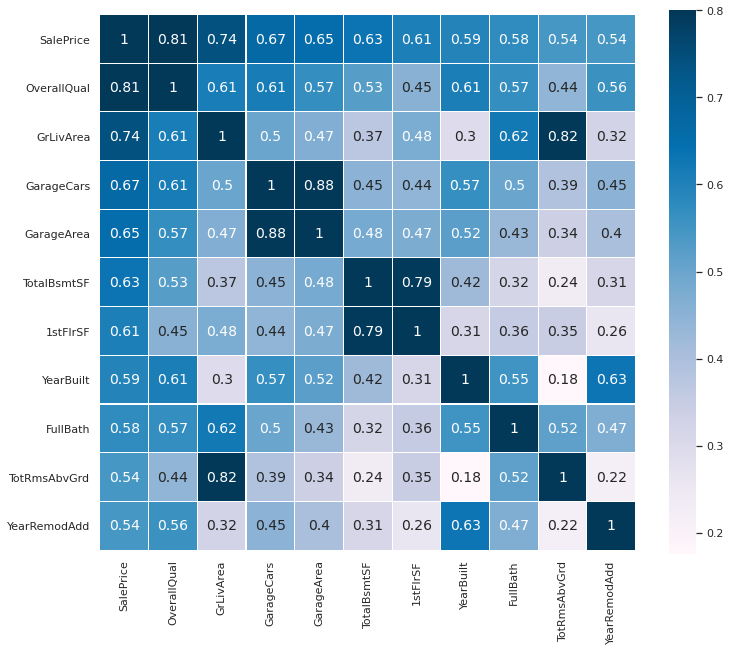

In [ ]:
k= 11
cols = corr_data.corr().nlargest(k,'SalePrice')['SalePrice'].index  # SalePrice와 상관관계가 높은 상위 11개의 index 추출
print(cols)
cm = np.corrcoef(housing_train[cols].values.T)
f , ax = plt.subplots(figsize = (12,10))
sns.heatmap(cm, vmax=.8, linewidths=0.1,square=True,annot=True,cmap=colormap,
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':14},yticklabels = cols.values)

# 가장 눈에 띄는 GarageCars와 GarageArea, TotalBsmtSF와 1stFlrSF는 서로 밀접하게 연관되어 있음을 알 수 있습니다.
# Target feature와 가장 밀접한 연관이 있는 feature는 'OverallQual', 'GrLivArea'및 'TotalBsmtSF'로 보입니다.
# 먼저 말했던 GarageCars와 GarageArea, TotalBsmtSF와 1stFlrSF, TotRmsAbvGrd와 GrLivArea는 모두 매우 유사한 정보를 포함하고 있으며 다중공선성이 나타난다고 할 수 있습니다. 
# SalePrice와 더 연관되어있는 변수인 GarageCars와 TotalBsmtSF, GrLivArea를 남기고 나머지는 이후에 버리도록 합니다.
# SalePrice와의 연관을 더 알아보기 위해 PairPlot을 그려보도록 합니다.

In [ ]:
corr_data.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.023298,-0.019343,-0.020261,-0.025092,0.008336,-0.007944,-0.015962,-0.049381,-0.008913,0.005311,-0.009603,-0.018371,0.000913,-0.008416,-0.047671,-0.010600,0.010611,-0.011931,-0.000439,-0.004682,0.022150,0.011507,0.004483,-0.023197,0.000068,0.006122,0.002045,-0.029269,-0.016951,0.021699,-0.058998,-0.019144,0.022904,-0.026685,0.034533,-0.003781,-0.024571
MSSubClass,0.023298,1.000000,-0.436559,-0.297088,0.074497,-0.092559,0.112764,0.059062,0.063942,-0.047603,-0.053434,-0.148923,-0.238894,-0.269960,0.288135,0.002338,0.060323,0.026243,-0.007595,0.122399,0.216815,-0.123750,0.175467,-0.019284,-0.019611,0.109812,-0.002868,-0.084141,-0.040956,0.022792,-0.049954,-0.033340,0.003331,-0.006978,-0.037427,-0.012753,-0.019476,-0.058747
LotFrontage,-0.019343,-0.436559,1.000000,0.565983,0.219484,-0.052162,0.126645,0.082199,0.154689,0.135176,0.013059,0.129522,0.294839,0.386134,0.045836,-0.060055,0.335830,0.068006,-0.023107,0.176961,0.043185,0.298075,0.018938,0.340096,0.222693,0.060893,0.295014,0.322386,0.106676,0.125950,-0.020514,0.081647,0.033189,0.014665,0.002357,0.032991,0.008749,0.362403
LotArea,-0.020261,-0.297088,0.565983,1.000000,0.134798,-0.036601,0.043240,0.038170,0.095748,0.164904,0.029718,0.048040,0.243834,0.305614,0.062545,-0.024037,0.289140,0.106085,0.003754,0.133641,0.047012,0.185889,-0.014604,0.239319,0.280137,-0.005621,0.192645,0.226823,0.180307,0.097054,-0.036838,0.035538,0.023836,0.002019,0.016758,0.004331,-0.041870,0.323844
OverallQual,-0.025092,0.074497,0.219484,0.134798,1.000000,-0.134320,0.608524,0.559699,0.399365,0.194672,-0.069487,0.305442,0.526298,0.453857,0.292017,-0.056633,0.611752,0.099960,-0.031812,0.568741,0.260712,0.110632,-0.169348,0.442791,0.379085,0.562570,0.612411,0.568546,0.249079,0.315144,-0.130439,0.036993,0.053747,-0.002512,-0.009931,0.086083,-0.028906,0.813443
OverallCond,0.008336,-0.092559,-0.052162,-0.036601,-0.134320,1.000000,-0.397369,0.030348,-0.156167,-0.038951,0.074326,-0.157029,-0.189534,-0.174277,-0.001141,0.038987,-0.131128,-0.048921,0.112875,-0.246909,-0.054885,0.017749,-0.102892,-0.084724,-0.045672,-0.363549,-0.210094,-0.177582,-0.023082,-0.089281,0.096387,-0.005367,0.057433,0.016605,0.092242,-0.005246,0.047547,-0.137218
YearBuilt,-0.007944,0.112764,0.126645,0.043240,0.608524,-0.397369,1.000000,0.629314,0.309703,0.227817,-0.053693,0.173251,0.420193,0.314487,0.068543,-0.110857,0.295031,0.179909,-0.027997,0.551538,0.235330,-0.012769,-0.106170,0.175480,0.151916,0.857485,0.566990,0.521435,0.249119,0.260470,-0.393848,0.031284,-0.037945,0.003512,-0.031155,0.015010,-0.013816,0.593385
YearRemodAdd,-0.015962,0.059062,0.082199,0.038170,0.559699,0.030348,0.629314,1.000000,0.171089,0.113711,-0.043700,0.184723,0.313291,0.260415,0.143170,-0.080931,0.324913,0.128807,-0.013424,0.469678,0.183953,-0.019123,-0.153690,0.220885,0.101124,0.657682,0.450971,0.403311,0.221048,0.269548,-0.207347,0.034526,-0.032955,0.006694,0.009851,0.021768,0.030152,0.544597
MasVnrArea,-0.049381,0.063942,0.154689,0.095748,0.399365,-0.156167,0.309703,0.171089,1.000000,0.221717,-0.071326,0.106083,0.331379,0.306937,0.170975,-0.052309,0.387569,0.090553,-0.009163,0.265964,0.195935,0.107619,-0.007361,0.275411,0.225824,0.250026,0.357616,0.359126,0.159621,0.118617,-0.106139,0.026648,0.076051,-0.010723,-0.022788,0.021498,-0.025651,0.474546
BsmtFinSF1,-0.008913,-0.047603,0.135176,0.164904,0.194672,-0.038951,0.227817,0.113711,0.221717,1.000000,-0.057327,-0.552203,0.442555,0.374438,-0.184131,-0.054315,0.111593,0.665260,0.077314,0.037771,-0.023076,-0.103342,-0.051477,-0.009036,0.206695,0.152056,0.204415,0.254401,0.192904,0.084420,-0.11814

### Pair Plot

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


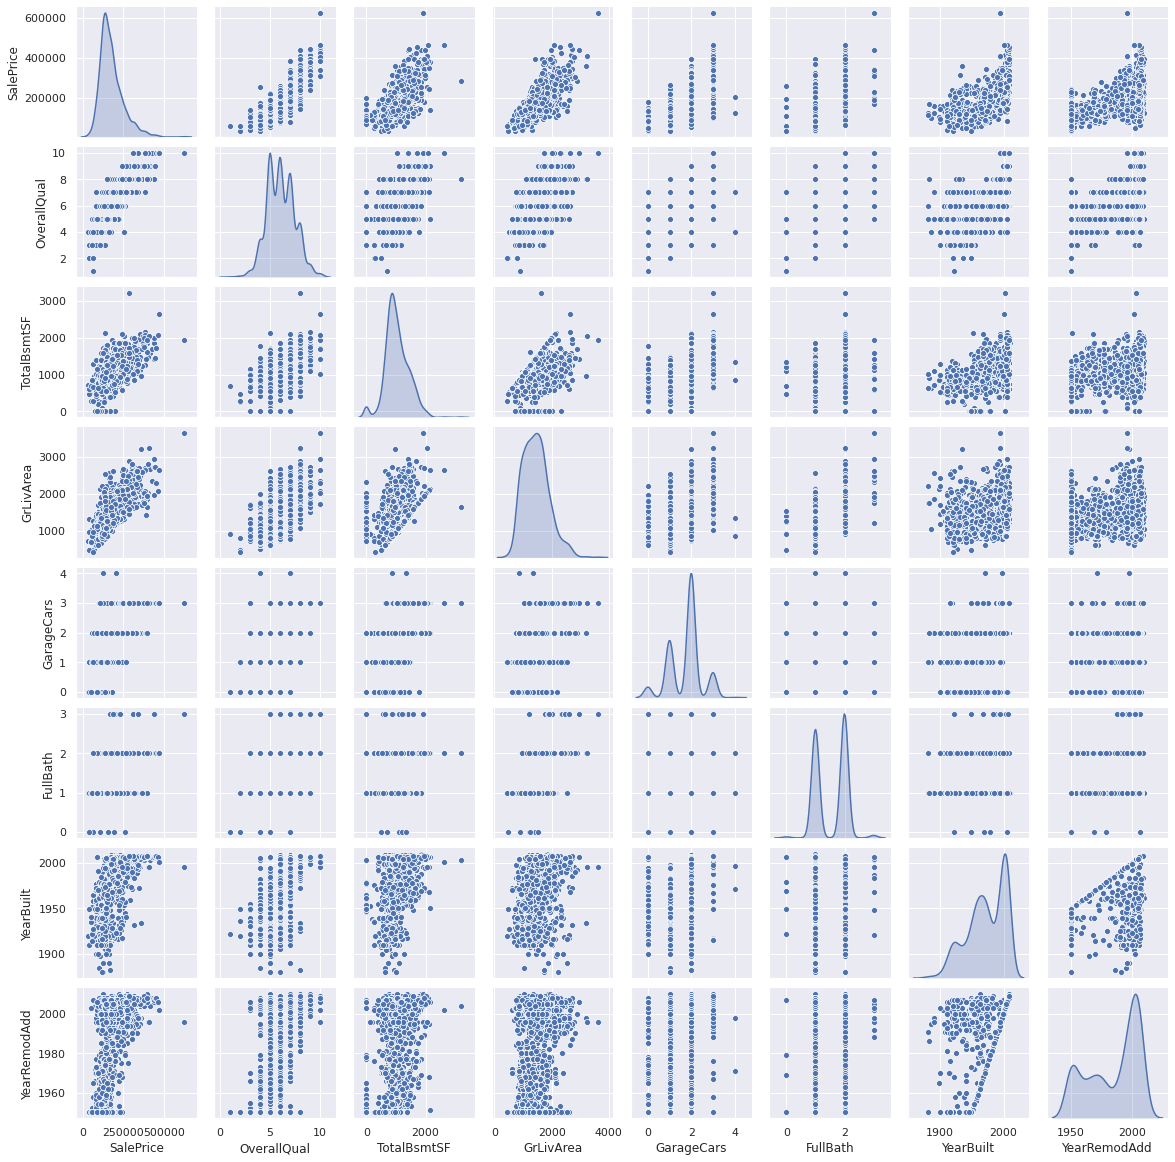

In [ ]:
sns.set()
columns = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(housing_train[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

# 위의 Zoomed Heat Map에서 다중공선성을 보이는 변수 중 SalePrice와 연관이 덜 한 변수를 제외하고 PairPlot을 그립니다.
# 'TotalBsmtSF'와 'GrLiveArea'는 데이터 설명에서 알 수 있듯이 지하실의 면적과 생활공간 면적을 의미합니다.
# 'TotalBsmtSF'와 'GrLiveArea'의 plot을 보면 점들이 직선처럼 그려지고 대부분의 점은 해당 선 아래에 유지됩니다. 
# 이것은 일반적으로 지하실 면적이 지상 생활 면적과 같을 수 있지만, 더 크진 않기 때문에 보여지는 특징이라고 할 수 있습니다.
# 'SalePrice'와 'YearBuilt'의 plot을 보면 우상향 곡선을 보입니다.
# 이것은 전년도 대비 주택 가격 상승의 가속을 의미한다고 할 수 있습니다.

### Scatter Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


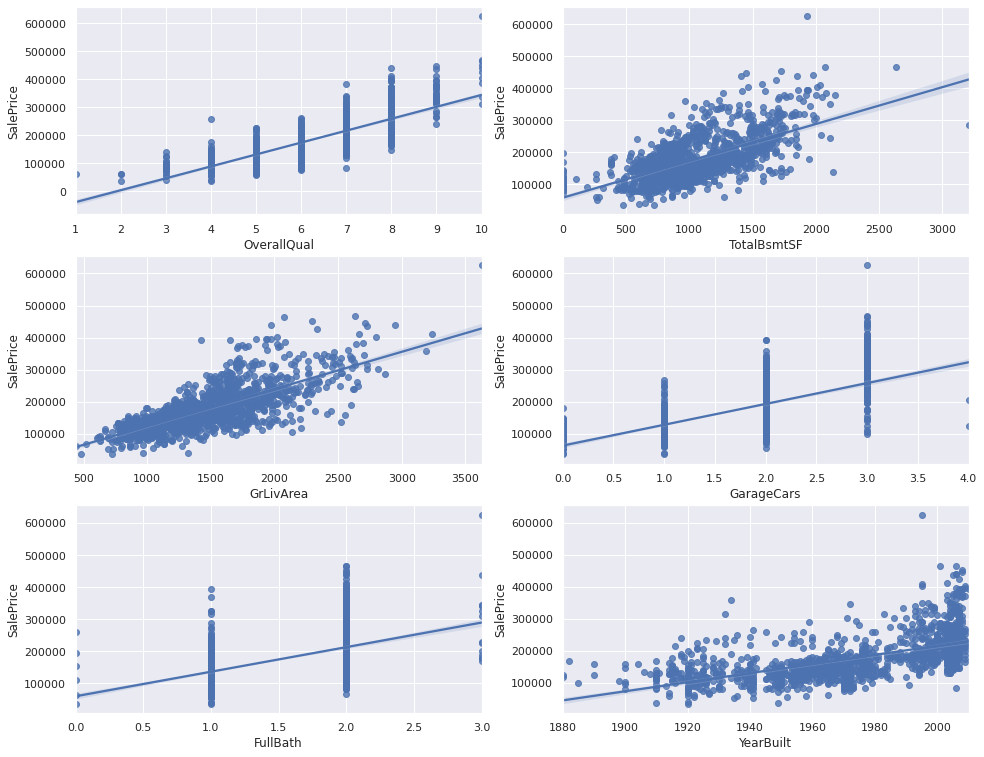

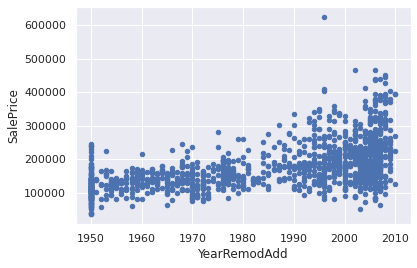

In [ ]:
fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(16,13))
OverallQual_scatter_plot = pd.concat([housing_train['SalePrice'],housing_train['OverallQual']],axis = 1)
sns.regplot(x='OverallQual',y = 'SalePrice',data = OverallQual_scatter_plot,scatter= True, fit_reg=True, ax=ax1)
TotalBsmtSF_scatter_plot = pd.concat([housing_train['SalePrice'],housing_train['TotalBsmtSF']],axis = 1)
sns.regplot(x='TotalBsmtSF',y = 'SalePrice',data = TotalBsmtSF_scatter_plot,scatter= True, fit_reg=True, ax=ax2)
GrLivArea_scatter_plot = pd.concat([housing_train['SalePrice'],housing_train['GrLivArea']],axis = 1)
sns.regplot(x='GrLivArea',y = 'SalePrice',data = GrLivArea_scatter_plot,scatter= True, fit_reg=True, ax=ax3)
GarageCars_scatter_plot = pd.concat([housing_train['SalePrice'],housing_train['GarageCars']],axis = 1)
sns.regplot(x='GarageCars',y = 'SalePrice',data = GarageCars_scatter_plot,scatter= True, fit_reg=True, ax=ax4)
FullBath_scatter_plot = pd.concat([housing_train['SalePrice'],housing_train['FullBath']],axis = 1)
sns.regplot(x='FullBath',y = 'SalePrice',data = FullBath_scatter_plot,scatter= True, fit_reg=True, ax=ax5)
YearBuilt_scatter_plot = pd.concat([housing_train['SalePrice'],housing_train['YearBuilt']],axis = 1)
sns.regplot(x='YearBuilt',y = 'SalePrice',data = YearBuilt_scatter_plot,scatter= True, fit_reg=True, ax=ax6)
YearRemodAdd_scatter_plot = pd.concat([housing_train['SalePrice'],housing_train['YearRemodAdd']],axis = 1)
YearRemodAdd_scatter_plot.plot.scatter('YearRemodAdd','SalePrice')

# Target Feature "SalePrice"와 가장 밀접한 연관이 있다고 판단됐던 변수들의 Scatter Plot을 그립니다.
# OverallQual, GarageCars, Fullbath와 같은 변수들은 실제로는 범주형 데이터의 특징을 보인다고 할 수 있습니다. (등급, 갯수 등을 의미하기 때문)

## 3.2. Categorical Data 탐색

남은 범주형 변수들도 확인해봅니다.<br>
질적 변수를 사용하여 두 가지 방법을 구현할 수 있습니다.<br>
첫 번째는 변수 값과 관련하여 SalePrice의 분포를 확인합니다.<br>
두 번째로 가능한 범주별로 더미 변수를 만듭니다.

In [ ]:
for catg in list(categorical_feats) :
    print(housing_train[catg].value_counts())
    print('#'*50)
    
# 범주형 변수들과 각 범주들을 확인합니다.

RL         1055
RM          197
FV           65
RH           14
C (all)       7
Name: MSZoning, dtype: int64
##################################################
Pave    1335
Grvl       3
Name: Street, dtype: int64
##################################################
Grvl    42
Pave    37
Name: Alley, dtype: int64
##################################################
Reg    859
IR1    440
IR2     32
IR3      7
Name: LotShape, dtype: int64
##################################################
Lvl    1211
Bnk      52
HLS      48
Low      27
Name: LandContour, dtype: int64
##################################################
AllPub    1338
Name: Utilities, dtype: int64
##################################################
Inside     972
Corner     235
CulDSac     81
FR2         46
FR3          4
Name: LotConfig, dtype: int64
##################################################
Gtl    1275
Mod      56
Sev       7
Name: LandSlope, dtype: int64
##################################################
NAmes      20

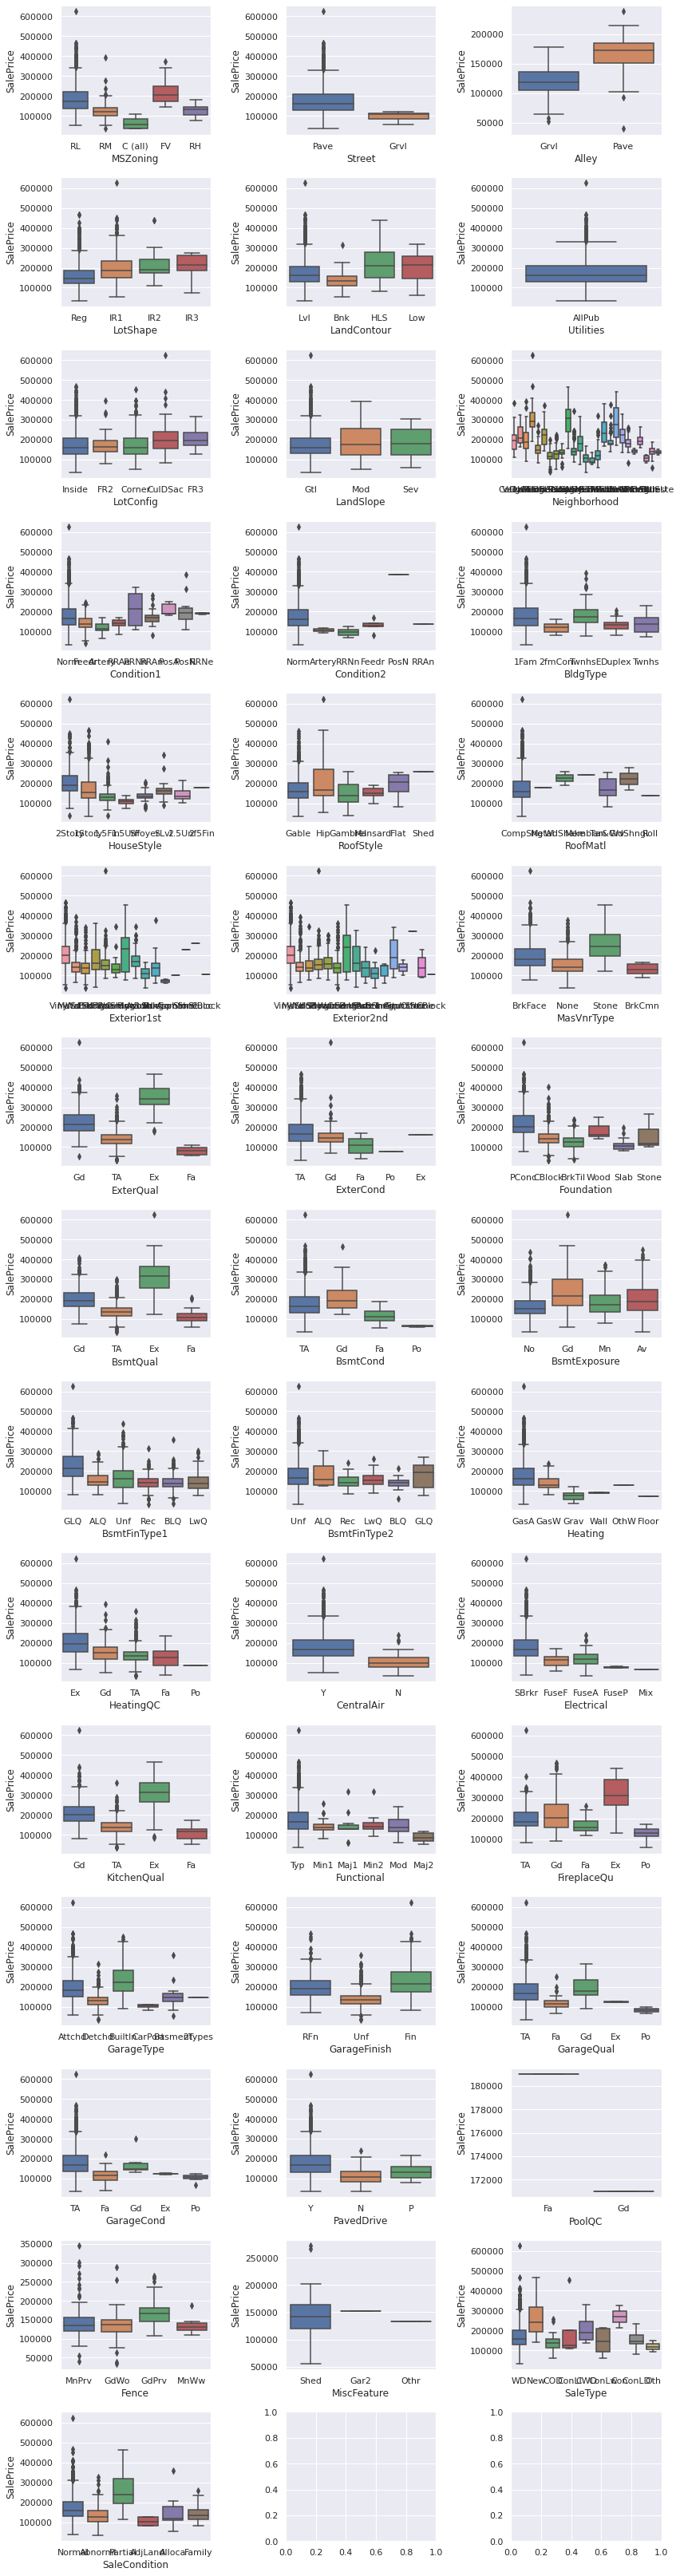

In [ ]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=housing_train["SalePrice"], data=housing_train, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()

# BoxPlot을 그려 Categorical Feature와 SalePrice의 관계를 확인합니다.
# 일부 범주는 다른 범주보다 SalePrice와 관련하여 더 다양하게 보입니다. 
# Neighborhood 변수는 주택 가격 편차가 매우 크므로 영향이 크다고 생각됩니다.
# SaleType 또한 마찬가지입니다.
# 또한 수영장이 있으면 가격이 크게 증가하는 것 같습니다. --> Is it real?
##################################################
# PoolQC: Pool quality
		
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        NA	No Pool
##################################################
# 정리하면 SalePrice에 영향을 많이 끼치는 변수로는 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual', 'CentralAir', 'Electrical', 'KitchenQual', 'SaleType' 등이 있습니다.

In [ ]:
num_strong_corr = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars',
                   'FullBath','YearBuilt','YearRemodAdd']

num_weak_corr = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'BsmtFullBath',
                 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

catg_strong_corr = ['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual',
                    'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]

# 편의를 위해 SalePrice와 관련이 큰 변수와 아닌 변수를 분리해놓습니다.
# "Id"는 submission 때문에 따로 빼놓겠습니다.

# 4. Feature Engineering

## 4.1. log 변환

Skewness: 1.287364
Kurtosis: 2.555029


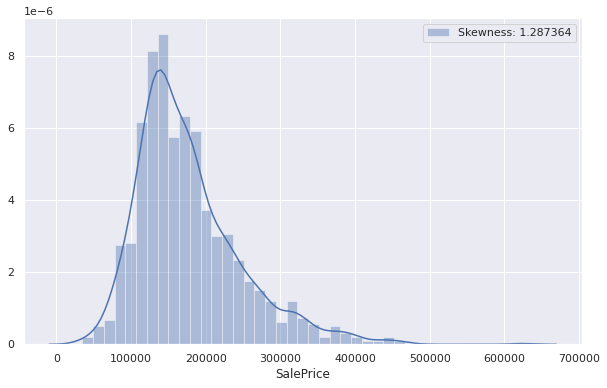

In [ ]:
f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(housing_train["SalePrice"], color = "b", label="Skewness: {:2f}".format(housing_train["SalePrice"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % housing_train["SalePrice"].skew())
print("Kurtosis: %f" % housing_train["SalePrice"].kurt())

# Target Feature인 SalePrice의 비대칭도와 첨도를 확인합니다. 
# 그래프와 수치를 확인하면 정상적으로 분포되지 않는것을 확인할 수 있습니다. 
# 예측의 정확도를 높히기 위해 로그 변환을 수행합니다.

Skewness: -0.032026
Kurtosis: 0.571897


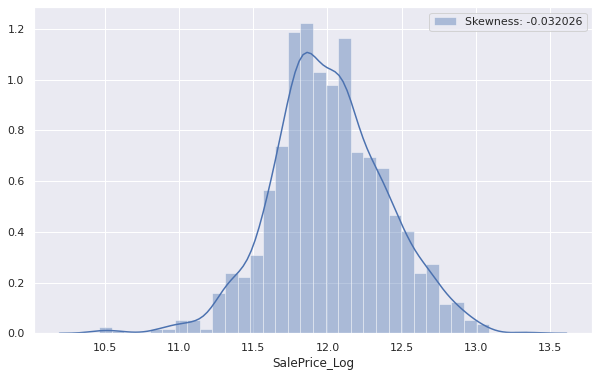

In [ ]:
housing_train["SalePrice_Log"] = housing_train["SalePrice"].map(lambda i:np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(housing_train["SalePrice_Log"], color = "b", label="Skewness: {:2f}".format(housing_train["SalePrice_Log"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % housing_train['SalePrice_Log'].skew())
print("Kurtosis: %f" % housing_train['SalePrice_Log'].kurt())

housing_train.drop('SalePrice', axis= 1, inplace=True)

# Skewness, Kurtosis를 없애주기 위해 로그를 취해줍니다.
# Log변환을 수행한 새로운 feature "SalePrice_Log"를 만들고 전 Feature인 "Saleprice"를 버려줍니다.
# 로그를 취해준 그래프와 수치가 바뀐 모습을 볼 수 있습니다. (정규근사화)

Data Check 과정에서 살펴봤을 때 Skewness와 Kurtosis가 보이는 변수들이 꽤 있었습니다.<br>
하지만 EDA 과정에서 중요하다고 판단되었던 Numerical feature들은 Skewness와 Kurtosis가 수치적으로 보이지 않으므로 Target Feature인 SalePrice만 Log를 취해줍니다.

## 4.2. 결측 데이터 처리

집값 예측 문제에는 굉장히 많은 NaN 데이터가 포함되어있습니다.<br>
하지만 여러 변수들의 특징을 잘 살펴보면 NaN의 의미를 재파악할 수 있습니다.<br>
단지 있다, 없다 개념일뿐 측정되지 않은 데이터의 의미가 아닙니다.<br>
이러한 변수들의 특징을 잘 파악하여 결측 데이터를 처리해주도록 합니다.

In [ ]:
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
    housing_train[col].fillna('None',inplace=True)
    housing_test[col].fillna('None',inplace=True)
    
# 위에서 설명한 바와 같이 '없다'의 의미를 갖는 변수들입니다.
# NaN을 없다는 의미의 None으로 대체해줍니다. --> pipeline 필요성

In [ ]:
total = housing_train.isnull().sum().sort_values(ascending=False)
percent = (housing_train.isnull().sum()/housing_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

# 결측치의 처리 정도를 확인해 줍니다.

,Total,Percent
LotFrontage,229,0.171151
GarageYrBlt,65,0.048580
MasVnrArea,7,0.005232
SalePrice_Log,0,0.000000
ExterCond,0,0.000000


In [ ]:
housing_train.fillna(housing_train.mean(), inplace=True)
housing_test.fillna(housing_test.mean(), inplace=True)

# 나머지 결측치들은 평균값으로 대체하겠습니다.

In [ ]:
total = housing_train.isnull().sum().sort_values(ascending=False)
percent = (housing_train.isnull().sum()/housing_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

# 다시 확인해보면 결측치가 사라진 것을 알 수 있습니다.

,Total,Percent
SalePrice_Log,0,0.0
Heating,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0


In [ ]:
housing_train.isnull().sum().sum(), housing_test.isnull().sum().sum()

(0, 0)

## 4.3. 유의하지 않은 변수 삭제

In [ ]:
id_test = housing_test['Id']

to_drop_num  = num_weak_corr
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg 

for df in [housing_train, housing_test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)
    
# SalePrice와의 상관관계가 약한 모든 변수를 삭제합니다.

In [ ]:
housing_train.head()

# 삭제가 잘 진행되었는지 확인합니다.

,MSZoning,Neighborhood,Condition2,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,Electrical,GrLivArea,FullBath,KitchenQual,GarageCars,SaleType,SalePrice_Log
0,RL,CollgCr,Norm,7,2003,2003,BrkFace,Gd,Gd,856,Y,SBrkr,1710,2,Gd,2,WD,12.247694
1,RL,Veenker,Norm,6,1976,1976,None,TA,Gd,1262,Y,SBrkr,1262,2,TA,2,WD,12.109011
2,RL,CollgCr,Norm,7,2001,2002,BrkFace,Gd,Gd,920,Y,SBrkr,1786,2,Gd,2,WD,12.317167
3,RL,Crawfor,Norm,7,1915,1970,None,TA,TA,756,Y,SBrkr,1717,1,Gd,3,WD,11.849398
4,RL,NoRidge,Norm,8,2000,2000,BrkFace,Gd,Gd,1145,Y,SBrkr,2198,2,Gd,3,WD,12.429216


## 4.4. Categorical Data 수치형 변환

EDA과정의 Boxplot에서 보았던 SalePrice에 영향이 큰 변수들을 변환해줍니다.<br>
먼저 ViolinPlot을 그려 각 범주들과 SalePrice의 관계를 살펴봅니다

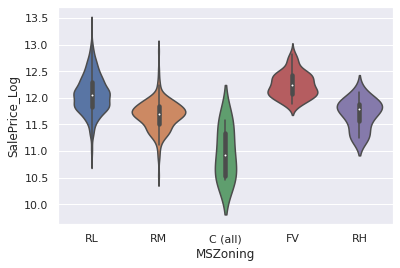

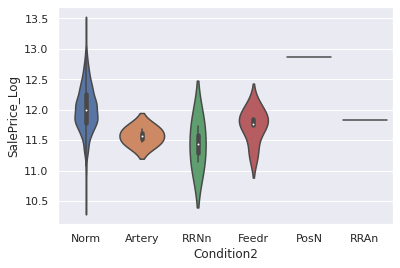

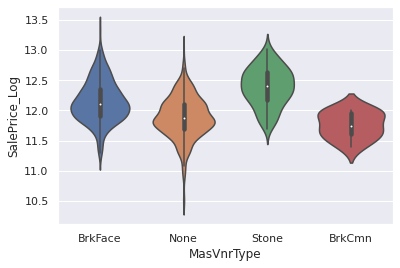

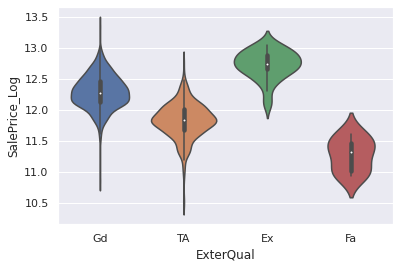

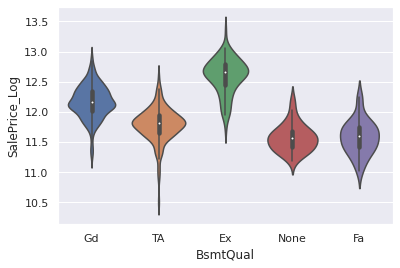

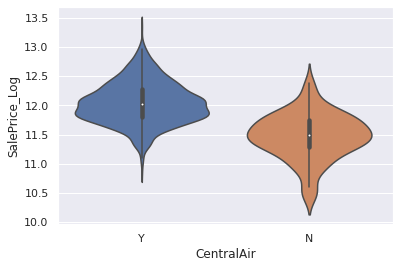

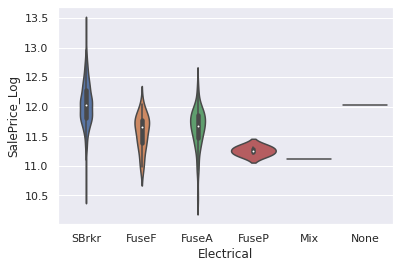

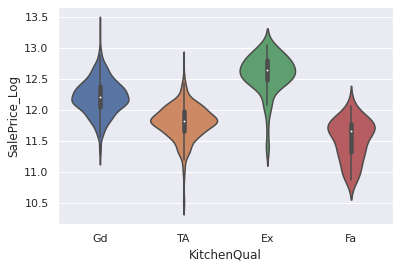

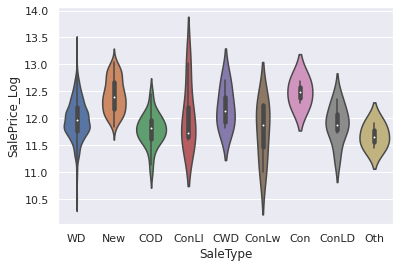

In [ ]:
catg_list = catg_strong_corr.copy()
catg_list.remove('Neighborhood')

for catg in catg_list :
    sns.violinplot(x=catg, y=housing_train["SalePrice_Log"], data=housing_train)
    plt.show()
    
# 각 범주들을 개별로 살펴봅니다.

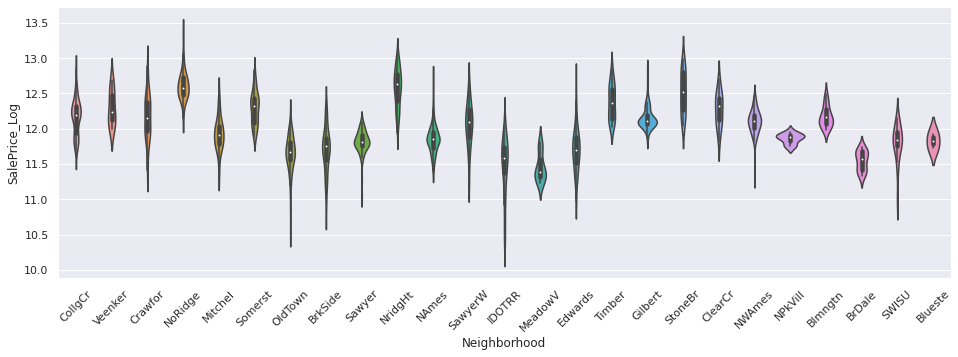

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='Neighborhood', y=housing_train["SalePrice_Log"], data=housing_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

# 범주가 가장 많은 Neighborhood 변수도 살펴봅니다.

In [ ]:
for catg in catg_list :
    g = housing_train.groupby(catg)["SalePrice_Log"].mean()
    print(g)
    
# 각 범주들에 해당되는 SalePrice_Log 평균을 살펴봅니다.  

MSZoning
C (all)    10.960733
FV         12.246616
RH         11.700602
RL         12.069474
RM         11.677434
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.734675
Norm      12.012766
PosN      12.860999
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.757397
BrkFace    12.150038
None       11.884715
Stone      12.391766
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.727937
Fa    11.274881
Gd    12.295102
TA    11.828332
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.595497
Fa      11.585725
Gd      12.170320
None    11.572903
TA      11.791989
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.471479
Y    12.042717
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.641350
FuseF    11.565700
FuseP    11.256345
Mix      11.112448
None     12.028739
SBrkr    12.047595
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.582467
Fa    11.514567
Gd    12.209558
TA    11.

In [ ]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']

# 수치형 변환을 위해 Violinplot과 SalePrice_Log 평균을 참고하여 각 변수들의 범주들을 그룹화 합니다.

In [ ]:
for df in [housing_train, housing_test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4 
    
# 각 범주별로 수치형 변환을 실행합니다.

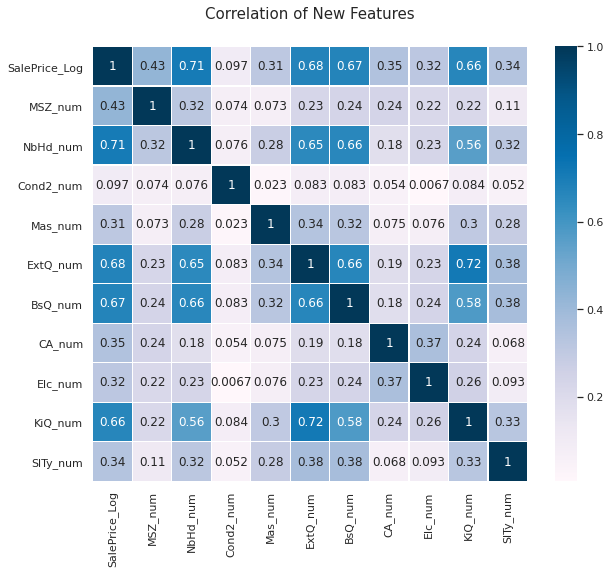

In [ ]:
new_col_HM = housing_train[['SalePrice_Log', 'MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']]

colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("Correlation of New Features", y = 1.05, size = 15)
sns.heatmap(new_col_HM.corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 12})

# 변환하여 새로 만들어진 numerical feature들 또한 Heat Map을 그려봅니다.
# NbHd_num, ExtQ_num, BsQ_num, KiQ_num를 제외하고는 SalePrice_Log와 큰 상관관계가있는 열은 거의 없습니다.

In [ ]:
housing_train.drop(['MSZoning','Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType', 'Cond2_num', 'Mas_num', 'CA_num', 'Elc_num', 'SlTy_num'], axis = 1, inplace = True)
housing_test.drop(['MSZoning', 'Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType', 'Cond2_num', 'Mas_num', 'CA_num', 'Elc_num', 'SlTy_num'], axis = 1, inplace = True)

# 기존 범주형 변수와 새로 만들어진 수치형 변수 역시 유의하지 않은 것들은 삭제합니다.

In [ ]:
housing_train.head()

# 완벽히 삭제되어 유의하다고 판단되는 수치형 변수만 남았습니다.

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageCars,SalePrice_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,7,2003,2003,856,1710,2,2,12.247694,3,2,3,2,3
1,6,1976,1976,1262,1262,2,2,12.109011,3,2,2,2,2
2,7,2001,2002,920,1786,2,2,12.317167,3,2,3,2,3
3,7,1915,1970,756,1717,1,3,11.849398,3,2,2,1,3
4,8,2000,2000,1145,2198,2,3,12.429216,3,3,3,2,3


In [ ]:
housing_test.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageCars,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,5,1961,1961,882.0,896,1,1.0,2,1,2,1,2
1,6,1958,1958,1329.0,1329,1,1.0,3,1,2,1,3
2,5,1997,1998,928.0,1629,2,2.0,3,2,2,2,2
3,6,1998,1998,926.0,1604,2,2.0,3,2,2,1,3
4,8,1992,1992,1280.0,1280,2,2.0,3,3,3,2,3


In [ ]:
housing_train.shape,housing_test.shape

((1338, 13), (1459, 12))

# 5. Modeling

## Model: XGBoost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train = housing_train.drop("SalePrice_Log", axis = 1).values
target_label = housing_train["SalePrice_Log"].values
X_test = housing_test.values
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size = 0.2, random_state = 2000)

# Test하기 전 Validation 과정을 겨처줍니다.
# train데이터의 20%를 validation으로 주고 80%을 train으로 남겨주어 분리해줍니다.

In [ ]:
import xgboost
regressor = xgboost.XGBRegressor(colsample_bytree = 0.4603, learning_rate = 0.06, min_child_weight = 1.8,
                                 max_depth= 3, subsample = 0.52, n_estimators = 2000,
                                 random_state= 7, ntrhead = -1)
regressor.fit(X_tr,y_tr)
xgboost.XGBRegressor.score()
# XGBoost 모델을 만들어줍니다.

[14:44:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0,
             importance_type='gain', learning_rate=0.06, max_delta_step=0,
             max_depth=3, min_child_weight=1.8, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, ntrhead=-1, objective='reg:linear',
             random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.52, verbosity=1)

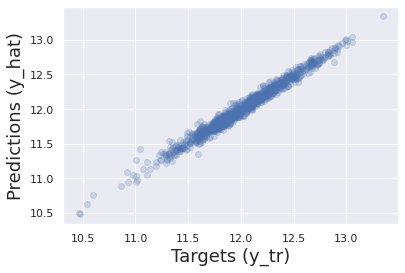

In [ ]:
y_hat = regressor.predict(X_tr)

plt.scatter(y_tr, y_hat, alpha = 0.2)
plt.xlabel('Targets (y_tr)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

# 예측 된 y 값 (y_hat)에 대한 Scatter Plot을 그려봅니다.

In [ ]:
regressor.score(X_tr,y_tr)

0.9778929954593789

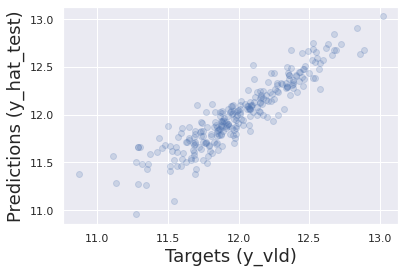

In [ ]:
y_hat_test = regressor.predict(X_vld)


plt.scatter(y_vld, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_vld)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.show()

# validation으로 예측해봅니다.

In [ ]:
regressor.score(X_vld,y_vld)

0.8387039163837681

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regressor, X = X_tr, y = y_tr, cv = 10)

# k-fold validation을 수행합니다.

[14:45:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
print(accuracies.mean())
print(accuracies.std())

# 정확도를 확인해봅니다.

0.8463773269333027
0.03393380365418177


# 6. Submission

In [ ]:
use_logvals = 1

pred_xgb = regressor.predict(X_test)

sub_xgb = pd.DataFrame()
sub_xgb['Id'] = id_test
sub_xgb['SalePrice'] = pred_xgb

if use_logvals == 1:
    sub_xgb['SalePrice'] = np.exp(sub_xgb['SalePrice']) 

sub_xgb.to_csv('xgb.csv',index=False)

# use_logvals는 Log를 취해준 Target feature을 exp해주기 위해 사용되는 스위치 역할입니다.
# 제대로 된 예측을 위해 학습 후 Log변환을 풀어줘야하기 때문입니다.
# 이 셀의 코드를 통해 submission까지 완료하게됩니다.